
# 📊 Unemployment Analysis  
_Professional notebook prepared for CodeAlpha Internship_  

**Author:** José Antônio Afonso (Afonso)**  
**Date:** 2025-11-01 01:33 UTC**


---


In [1]:
# 1️⃣ Imports and settings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = (10,5)
pd.set_option('display.max_columns', 50)


## 2️⃣ Load and Clean Data

In [2]:
def load_and_clean(path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()

    # Detect and convert date column
    date_col = 'Date'
    if date_col not in df.columns:
        for c in df.columns:
            if 'date' in c.lower():
                date_col = c
                break
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
    df = df.dropna(subset=[date_col])

    # Detect unemployment column
    possible_cols = [c for c in df.columns if 'unemployment' in c.lower()]
    rate_col = possible_cols[0] if possible_cols else df.columns[-1]
    df[rate_col] = (df[rate_col].astype(str)
                    .str.replace('%','', regex=False)
                    .str.replace(',','.', regex=False)
                    .astype(float))
    df = df.rename(columns={rate_col:'UnemploymentRate', date_col:'Date'})
    df = df.sort_values('Date')
    return df

paths = [
    "../data/Unemployment in India.csv",
    "../data/Unemployment_Rate_upto_11_2020.csv"
]

dfs = []
for p in paths:
    try:
        d = load_and_clean(p)
        print(f"Loaded {p} with shape {d.shape}")
        dfs.append(d)
    except Exception as e:
        print("Error loading", p, e)

df = pd.concat(dfs, ignore_index=True).sort_values('Date')
print("Combined dataset shape:", df.shape)
df.head()


Loaded ../data/Unemployment in India.csv with shape (740, 7)
Loaded ../data/Unemployment_Rate_upto_11_2020.csv with shape (267, 9)
Combined dataset shape: (1007, 10)


,Region,Date,Frequency,UnemploymentRate,Estimated Employed,Estimated Labour Participation Rate (%),Area,Region.1,longitude,latitude
0,Andhra Pradesh,2019-05-31,Monthly,3.65,11999139.0,43.24,Rural,NaN,NaN,NaN
29,Maharashtra,2019-05-31,Monthly,6.08,16962574.0,38.30,Urban,NaN,NaN,NaN
30,Jharkhand,2019-05-31,Monthly,17.23,2404033.0,43.25,Urban,NaN,NaN,NaN
31,Jammu & Kashmir,2019-05-31,Monthly,23.04,1130139.0,46.74,Urban,NaN,NaN,NaN
32,Himachal Pradesh,2019-05-31,Monthly,10.88,245668.0,45.27,Urban,NaN,NaN,NaN


In [3]:
df.duplicated().sum()

np.int64(0)

## 3️⃣ Exploratory Data Analysis

Date range: 2019-05-31 to 2020-10-31

Missing values per column:
 Region                                       0
Date                                         0
Frequency                                    0
UnemploymentRate                             0
Estimated Employed                           0
Estimated Labour Participation Rate (%)      0
Area                                       267
Region.1                                   740
longitude                                  740
latitude                                   740
dtype: int64


,Date,UnemploymentRate,Estimated Employed,Estimated Labour Participation Rate (%),longitude,latitude
count,1007,1007.000000,1.007000e+03,1007.000000,267.000000,267.000000
mean,2020-01-31 06:06:04.647467776,11.906991,8.996209e+06,42.378620,22.826048,80.532425
min,2019-05-31 00:00:00,0.000000,4.942000e+04,13.330000,10.850500,71.192400
25%,2019-09-30 00:00:00,4.685000,1.639125e+06,37.835000,18.112400,76.085600
50%,2020-01-31 00:00:00,8.890000,5.543380e+06,40.880000,23.610200,79.019300
75%,2020-05-31 00:00:00,16.125000,1.287115e+07,45.315000,27.278400,85.279900
max,2020-10-31 00:00:00,76.740000,5.943376e+07,72.570000,33.778200,92.937600
std,NaN,10.739549,1.020784e+07,8.048542,6.270731,5.831738


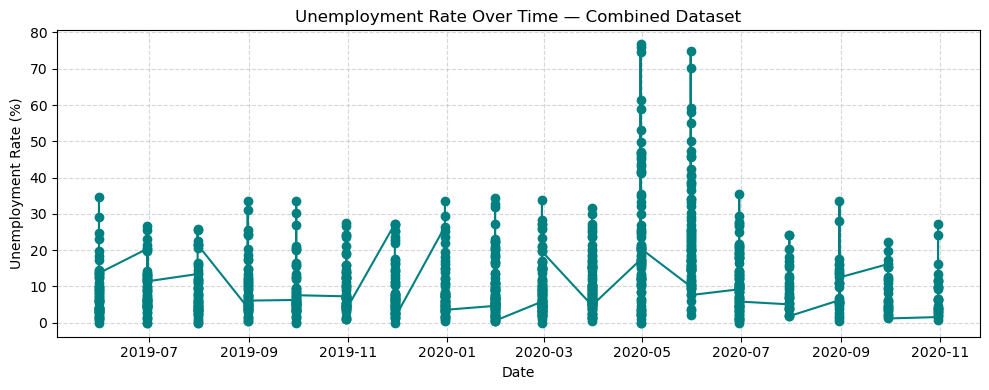

In [4]:
print("Date range:", df['Date'].min().date(), "to", df['Date'].max().date())
print("\nMissing values per column:\n", df.isnull().sum())
display(df.describe())

plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['UnemploymentRate'], marker='o', color='teal')
plt.title('Unemployment Rate Over Time — Combined Dataset')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 4️⃣ National Trend and Yearly Average

In [5]:
national = df[['Date','UnemploymentRate']].drop_duplicates().set_index('Date').asfreq('MS')
national['UnemploymentRate'] = national['UnemploymentRate'].interpolate()

fig, ax = plt.subplots()
national['UnemploymentRate'].plot(ax=ax, color='darkcyan', linewidth=2)
ax.set_title('National Average Unemployment Rate (Monthly)')
ax.set_ylabel('Unemployment Rate (%)')
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df['Year'] = df['Date'].dt.year
yearly = df.groupby('Year')['UnemploymentRate'].mean()

plt.figure(figsize=(8,4))
yearly.plot(kind='bar', color='orange')
plt.title('Average Unemployment Rate by Year')
plt.ylabel('Unemployment Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ValueError: cannot reindex on an axis with duplicate labels

## 5️⃣ Time Series Analysis — Seasonal Decomposition

In [ ]:
series = national['UnemploymentRate'].dropna()
if len(series) >= 24:
    result = seasonal_decompose(series, model='additive', period=12, extrapolate_trend='freq')
    fig = result.plot()
    fig.set_size_inches(12,8)
    plt.tight_layout()
    plt.show()
else:
    print("Series too short for decomposition (need >= 24 months).")


## 6️⃣ COVID-19 Impact Analysis

In [ ]:
df['Period'] = df['Date'].dt.year.apply(lambda y: 'pre-2020' if y < 2020 else ('2020' if y == 2020 else 'post-2020'))
avg_rates = df.groupby('Period')['UnemploymentRate'].mean()
print(avg_rates)

plt.figure(figsize=(6,4))
df.boxplot(column='UnemploymentRate', by='Period')
plt.title('Unemployment Rate by Period')
plt.suptitle('')
plt.ylabel('Unemployment Rate (%)')
plt.tight_layout()
plt.show()
